First let's fit our supernova synthetic data from last time using GPR.

The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.\
But check out what's available in the kernels submodule of sklearn.gaussian_process.\
Plot the expectation value of the fit as well as the resulting 1-$\sigma$ and 2-$\sigma$ contours.
Interpret the results.

Note. To start with, feel free to tweak the hyperparameters manually. But, of course, a publication-quality result will require a cross-validation analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
path = r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Utilities"
sys.path.append(path)
import plot_settings

In [2]:
data = np.genfromtxt(r'C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\Data\mu_z.txt', delimiter=' ')

In [3]:
z_sample  = data[:, 0]
mu_sample = data[:, 1]
dmu       = data[:, 2]

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ricca\AppData\Local\Temp\ipykernel_19432\2962798895.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


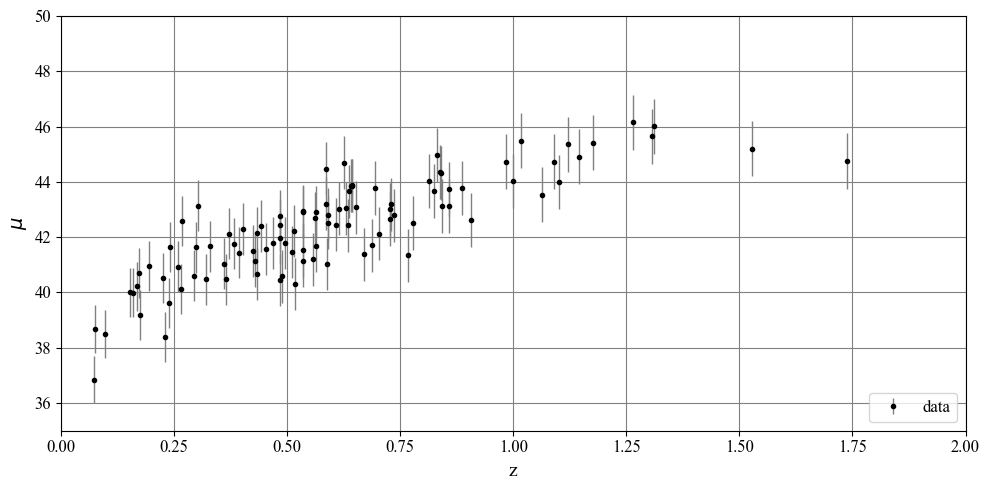

In [4]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

## GPR fit - RBF + Whiten

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
z_train, z_test, mu_train, mu_test = train_test_split(z_sample, mu_sample, test_size=0.2, random_state=42)

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
scaler = StandardScaler()
z_scaled = scaler.fit_transform(z_sample.reshape(-1, 1))
mu_scaled = scaler.fit_transform(mu_sample.reshape(-1, 1))
z_train_scaled = scaler.fit_transform(z_train.reshape(-1, 1))
mu_train_scaled = scaler.fit_transform(mu_train.reshape(-1, 1))
z_test_scaled = scaler.fit_transform(z_test.reshape(-1, 1))
mu_test_scaled = scaler.fit_transform(mu_test.reshape(-1, 1))

In [10]:
K = kernels.RBF(length_scale=0.1) + kernels.WhiteKernel()

In [11]:
GPR = GaussianProcessRegressor(kernel=K, n_restarts_optimizer=10, random_state=42)

In [12]:
GPR.fit(z_train_scaled, mu_train_scaled)

GaussianProcessRegressor(kernel=RBF(length_scale=0.1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10, random_state=42)

In [13]:
GPR.score(z_test_scaled, mu_test_scaled)

0.646430545172871

In [14]:
X_plot = np.linspace(z_train_scaled.min(), z_train_scaled.max(), 500)
mean, std = GPR.predict(X_plot.reshape(-1, 1), return_std=True)

(-3.0951937187192704, 2.1164384003766235)

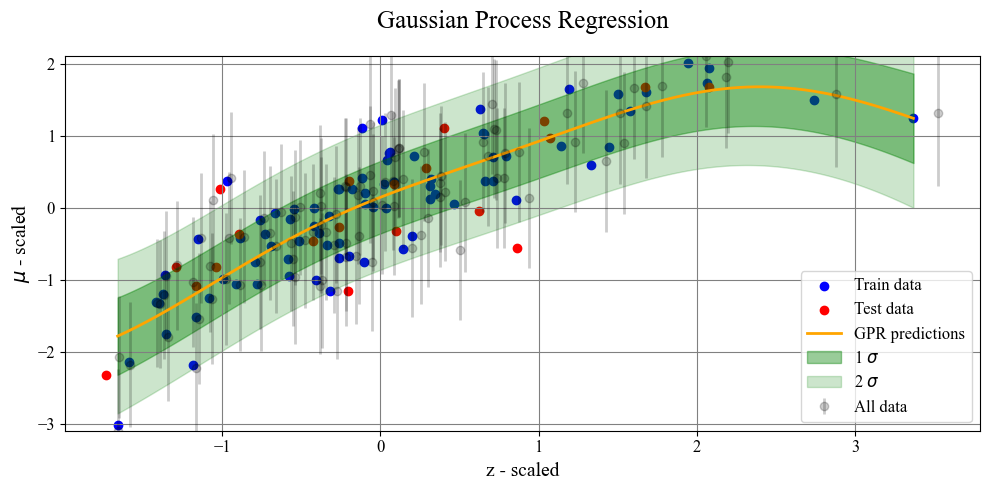

In [15]:
plt.errorbar(z_scaled.T[0], mu_scaled.T[0], dmu,  fmt='o', c='black', label='All data', alpha=0.2)
plt.scatter(z_train_scaled, mu_train_scaled, c='blue', label='Train data')
plt.scatter(z_test_scaled, mu_test_scaled, c='red', label='Test data')
plt.plot(X_plot, mean, c='orange', label='GPR predictions')
plt.fill_between(X_plot.ravel(), mean - std, mean + std, alpha=0.4, color='green', label=r"1 $\sigma$")
plt.fill_between(X_plot.ravel(), mean - 2*std, mean + 2*std, alpha=0.2, color='green', label=r"2 $\sigma$")
plt.xlabel("z - scaled")
plt.ylabel(r"$\mu$ - scaled")
plt.legend(loc='lower right')
plt.title("Gaussian Process Regression")
plt.ylim(mu_scaled.min(),mu_scaled.max())


In [479]:
print('log_likelihood:' ,GPR.log_marginal_likelihood())

log_likelihood: -67.04082873459778


Kernel is good! Now we can cross validate on noise level and scale length

In [482]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV

In [504]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [505]:
from itertools import product

In [506]:
length_scales = [0.01, 0.05, 0.1, 0.5, 1]
noise_levels = [1e-5, 1e-3, 1e-1, 1.0]

kernel_grid = [
    kernels.RBF(length_scale=l) + kernels.WhiteKernel(noise_level=n)
    for l, n in product(length_scales, noise_levels)
]

In [510]:
X = z_train_scaled.reshape(-1, 1)
y = mu_train_scaled

results = []
for kernel in kernel_grid:
    gpr = GaussianProcessRegressor(kernel=kernel, optimizer=None)  # Disable internal optimization
    score = cross_val_score(gpr, X, y, cv=kf, scoring='neg_mean_squared_error')
    results.append((kernel, score.mean()))

In [511]:
best_kernel, best_score = max(results, key=lambda x: x[1])
print(f"Best kernel: {best_kernel}")
print(f"Best CV score: {best_score}")

Best kernel: RBF(length_scale=1) + WhiteKernel(noise_level=0.1)
Best CV score: -0.27781829801457325


In [512]:
GPR = GaussianProcessRegressor(kernel=best_kernel, n_restarts_optimizer=10, random_state=42)
GPR.fit(z_train_scaled, mu_train_scaled)
GPR.score(z_test_scaled, mu_test_scaled)
X_plot = np.linspace(z_train_scaled.min(), z_train_scaled.max(), 500)
mean, std = GPR.predict(X_plot.reshape(-1, 1), return_std=True)

In [513]:
X_plot = np.linspace(z_train_scaled.min(), z_train_scaled.max(), 500)
mean, std = GPR.predict(X_plot.reshape(-1, 1), return_std=True)

(-3.0951937187192704, 2.1164384003766235)

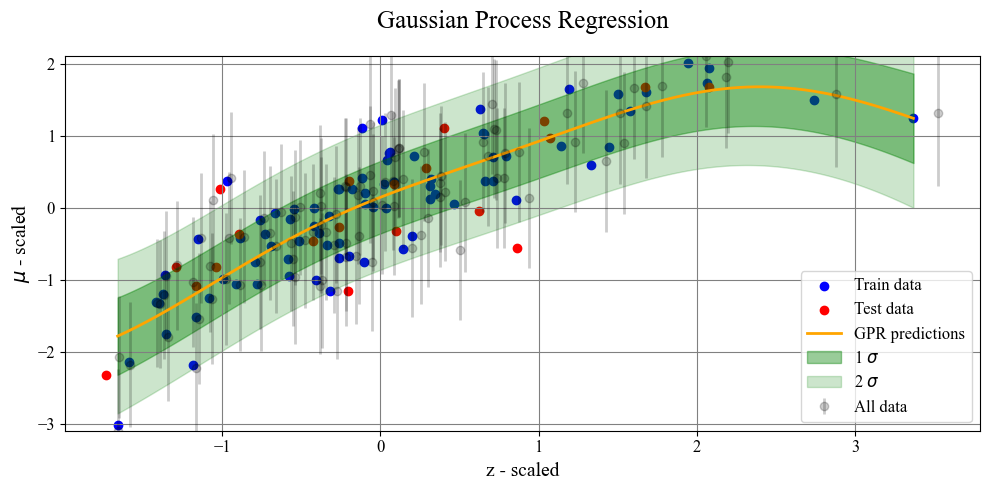

In [ ]:
plt.errorbar(z_scaled.T[0], mu_scaled.T[0], dmu,  fmt='o', c='black', label='All data', alpha=0.2)
plt.scatter(z_train_scaled, mu_train_scaled, c='blue', label='Train data')
plt.scatter(z_test_scaled, mu_test_scaled, c='red', label='Test data')
plt.plot(X_plot, mean, c='orange', label='GPR predictions')
plt.fill_between(X_plot.ravel(), mean - std, mean + std, alpha=0.4, color='green', label=r"1 $\sigma$")
plt.fill_between(X_plot.ravel(), mean - 2*std, mean + 2*std, alpha=0.2, color='green', label=r"2 $\sigma$")
plt.xlabel("z - scaled")
plt.ylabel(r"$\mu$ - scaled")
plt.legend(loc='lower right')
plt.title("Gaussian Process Regression")
plt.ylim(mu_scaled.min(),mu_scaled.max())